In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy.random import normal
import decimal
from math import comb
pd.set_option('precision',4)
plt.style.use('ggplot')

# True Price

In [2]:
r = 0.1
sigma = 0.16
S0 = 100
T = 1
K = 110

In [3]:
A = 1/sigma*(np.log(K/S0)-(r-sigma**2/2)*T)
C_true = np.exp(-r*T)*(1-norm.cdf(A))
print("The true value of the option is {:.4f}".format(C_true))

The true value of the option is 0.4341


# Binomial Tree

In [5]:
def combos(n,i):
    return comb(n,i)

def value(ST,K):
    return 1 if ST>K else 0

1244


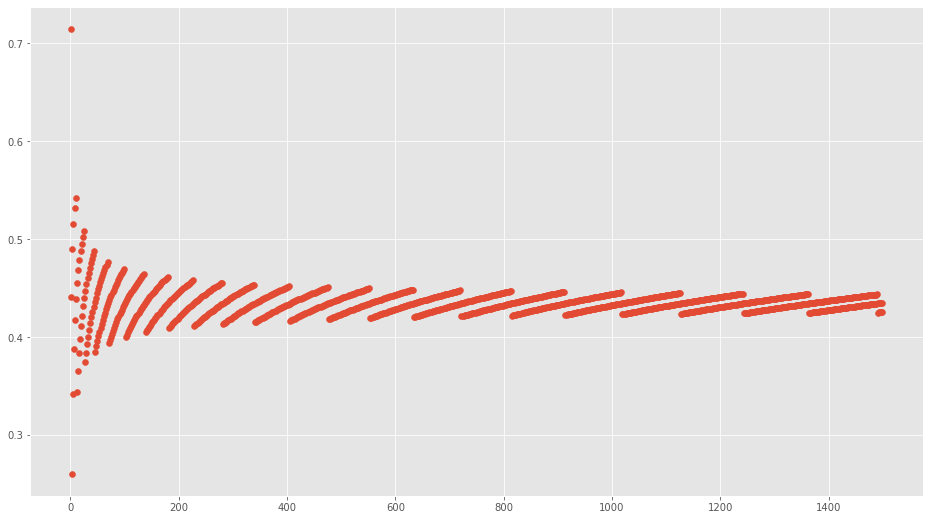

In [69]:
C_series = []
C_diff = []
N_prime = np.inf
N_max = 1500
N_min = 1
for N in range(N_min,N_max):
    # basic setup
    dt = T / N
    u = np.exp(sigma*np.sqrt(dt))
    d = np.exp(-sigma*np.sqrt(dt))
    p = (np.exp(r*dt)-d)/(u-d)
    C = 0
    decimal.getcontext().prec = N + 1
    
    # calculation
    for k in range(N+1):
        ST = S0 * u ** k * d ** (N-k)
        p_star = combos(N,k)*decimal.Decimal(str(p))**k*decimal.Decimal(str(1-p))**(N-k)
        C += value(ST,K) * p_star
        
    C0 = float(C) * np.exp(-r*T)
    C_series.append(C0)
    
    # find N prime
    C_diff.append(C0 - C_true)
    if (abs(C_diff[-1]) >= 0.01): 
        N_prime = np.inf
    elif (N_prime == np.inf):
        N_prime = N
        
print(N_prime)
plt.figure(figsize=(16, 9))
plt.scatter(x=range(N_min, N_max), y=C_series)

# Monte-Carlo simulation
## Without antithetic path

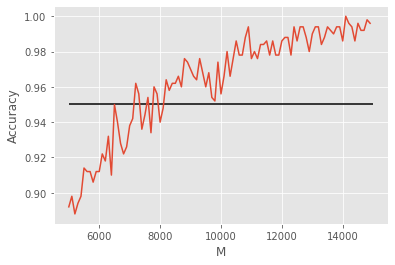

In [5]:
# M = 7560
r = 0.1
T = 1
sigma = 0.16
K = 110
S0 = 100
C_series = {}

for M in range(5000,15000,100):
    C_record = []
    for N_time in range(500):
        Y = T * (r-sigma**2/2) + np.sqrt(T) * sigma * normal(0,1,size=(M,1))
        P = np.exp(-r*T) * (K - S0*np.exp(Y)<=0)
        C_price = P.mean()
        C_record.append(C_price)
        
    C_record = np.array(C_record)
    proportion = (np.abs(C_record-C_true)<=0.01).sum()/500
    # print('M = {}     Proportion = {}'.format(M,proportion))
    C_series[M] = proportion
    
C_series = pd.Series(C_series)
C_series.plot()
plt.xlabel('M')
plt.ylabel('Accuracy')
plt.hlines(0.95,xmin=5000,xmax=15000,colors='black')


In [7]:
N = 100
M = 1000000
r = 0.1
T = 1
sigma = 0.16
K = 110
S0 = 100
dt = T/N

S = np.zeros((N,M))
S[0,:] = S0

for i in range(N-1):
    X = normal(0,np.sqrt(dt),size=(1,M))
    dS = S[i,:] * r * dt + S[i,:] * sigma * X 
    S[i+1,:] = S[i,:] + dS

C_price = (S[-1, :] >= K).sum()/M * np.exp(-r*T)
print(C_price)

0.43168164507143164


## With antithetic path

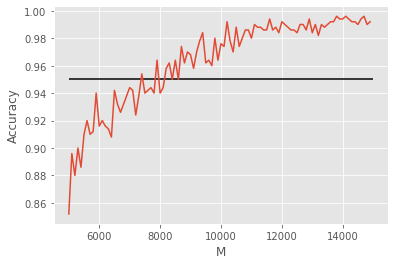

In [6]:
# M = 1000000
r = 0.1
T = 1
sigma = 0.16
K = 110
S0 = 100
C_series = {}

for M in range(5000,15000,100):
    C_record = []
    for N_time in range(500):
        Y = T * (r-sigma**2/2) + np.sqrt(T) * sigma * normal(0, 1, size=(M, 1))
        YM = T * (r-sigma**2/2) - np.sqrt(T) * sigma * normal(0, 1, size=(M, 1))
        P = np.exp(-r*T) * (K - S0*np.exp(Y) <= 0)
        PM = np.exp(-r*T) * (K - S0*np.exp(Y) <= 0)
        P = (P + PM)/2
        C_price = P.mean()
        C_record.append(C_price)
    
    C_record = np.array(C_record)
    proportion = (np.abs(C_record-C_true)<=0.01).sum()/500
    # print('M = {}     Proportion = {}'.format(M,proportion))
    C_series[M] = proportion
    
C_series = pd.Series(C_series)
C_series.plot()
plt.xlabel('M')
plt.ylabel('Accuracy')
plt.hlines(0.95, xmin=5000, xmax=15000, colors='black')


In [9]:
N = 1000
M = 100000
r = 0.1
T = 1
sigma = 0.16
K = 110
S0 = 100
dt = T/N

S1 = np.zeros((N, M))
S1[0, :] = S0
S2 = np.zeros((N, M))
S2[0, :] = S0

for i in range(N-1):
    X = normal(0, np.sqrt(dt), size=(1, M))
    dS1 = S1[i, :] * r * dt + S1[i, :] * sigma * X
    S1[i+1, :] = S1[i, :] + dS1
    dS2 = S2[i, :] * r * dt - S2[i, :] * sigma * X
    S2[i+1, :] = S2[i, :] + dS2

C_price = ((S1[-1, :] >= K).sum() + (S2[-1, :] >= K).sum())/(2*M) * np.exp(-r*T)
print(C_price)


0.43392835638041494
